In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sentence_transformers import SentenceTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv("../PreProcessingResumes/processed_data/Resume/train.csv")
df.head()

,ID,Resume_str,Category
0,28111403,president chief executive officer executive pr...,INFORMATION-TECHNOLOGY
1,29908929,business development marketing summary busines...,BUSINESS-DEVELOPMENT
2,15261348,chef restaurant manager summary chef year high...,CHEF
3,75435017,charge nurse professional summary objective ob...,HEALTHCARE
4,41152404,test analyst intern contractor profile year pr...,INFORMATION-TECHNOLOGY


In [3]:
# Convert resumes column to a list
resumes = df["Resume_str"].tolist()
    
# Encode category labels as integers
encoder = LabelEncoder()
labels = encoder.fit_transform(df["Category"])
category_names = encoder.classes_.tolist()

In [4]:
# Load the SBERT model for generating sentence embeddings
sbert_model = SentenceTransformer('all-MiniLM-L12-v2')

In [5]:
# Generate SBERT embeddings
resumes_embed = sbert_model.encode(resumes, show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

### Random Forest Classifier

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
class_counts = df['Category'].value_counts()
min_classes = class_counts[class_counts < 0.75*class_counts.mean()].index.tolist()

print(f"Applying SMOTE to classes: {min_classes}")

target_size = int(0.75*class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

In [ ]:
pipeline = Pipeline(steps=[
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=4)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=5))
])

In [ ]:
param_grid = {
    'clf__n_estimators': [400, 700],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [5, 7, 8],
    'clf__criterion' : ['gini', 'entropy'],
    'clf__min_samples_split': [10],
    'clf__min_samples_leaf': [15]
}

scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring= scoring,
    refit = False,
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(resumes_embed, labels)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.")

GridSearchCV took 669.67 seconds for 24 candidates parameter settings.


In [9]:
# Convert the cross-validation results from GridSearchCV into a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Sort the results by the weighted F1 score in descending order
results_df = results_df.sort_values(by='mean_test_f1_weighted', ascending=False).reset_index(drop=True)

In [ ]:
for i in range(len(results_df)):
    print(f"\n[{i+1}] Params: {results_df['params'][i]}")
    
    for metric in scoring:
        
        print(f"{metric.upper()}:")
        print(f"\tTRAIN:", end='')
        for fold in range(skf.get_n_splits()):
            print(f"\tFold {fold+1}: {results_df[f'split{fold}_train_{metric}'][i]:.4f}", end='')
        print(f"\t\tMean: {results_df[f'mean_train_{metric}'][i]:.4f}", end='')
        print(f"\tStd: {results_df[f'std_train_{metric}'][i]:.4f}")

        print(f"\tTEST:", end='')
        for fold in range(skf.get_n_splits()):
            print(f"\tFold {fold+1}: {results_df[f'split{fold}_test_{metric}'][i]:.4f}", end='')
        print(f"\t\tMean: {results_df[f'mean_test_{metric}'][i]:.4f}", end='')
        print(f"\tStd: {results_df[f'std_test_{metric}'][i]:.4f}\n")


[1] Params: {'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}
ACCURACY:
	TRAIN:	Fold 1: 0.9314	Fold 2: 0.9377	Fold 3: 0.9402	Fold 4: 0.9346	Fold 5: 0.9377		Mean: 0.9363  	Std: 0.0031
	TEST:	Fold 1: 0.7588	Fold 2: 0.7355	Fold 3: 0.7254	Fold 4: 0.7607	Fold 5: 0.7708		Mean: 0.7502  	Std: 0.0169

F1_WEIGHTED:
	TRAIN:	Fold 1: 0.9311	Fold 2: 0.9377	Fold 3: 0.9401	Fold 4: 0.9344	Fold 5: 0.9377		Mean: 0.9362  	Std: 0.0031
	TEST:	Fold 1: 0.7543	Fold 2: 0.7328	Fold 3: 0.7193	Fold 4: 0.7572	Fold 5: 0.7674		Mean: 0.7462  	Std: 0.0176

PRECISION_WEIGHTED:
	TRAIN:	Fold 1: 0.9336	Fold 2: 0.9396	Fold 3: 0.9418	Fold 4: 0.9369	Fold 5: 0.9393		Mean: 0.9382  	Std: 0.0028
	TEST:	Fold 1: 0.7644	Fold 2: 0.7501	Fold 3: 0.7223	Fold 4: 0.7691	Fold 5: 0.7776		Mean: 0.7567  	Std: 0.0194

RECALL_WEIGHTED:
	TRAIN:	Fold 1: 0.9314	Fold 2: 0.9377	Fold 3: 0.9402	Fold 4: 0.9346	Fold 5: 0.9377		Mean: 0.9363

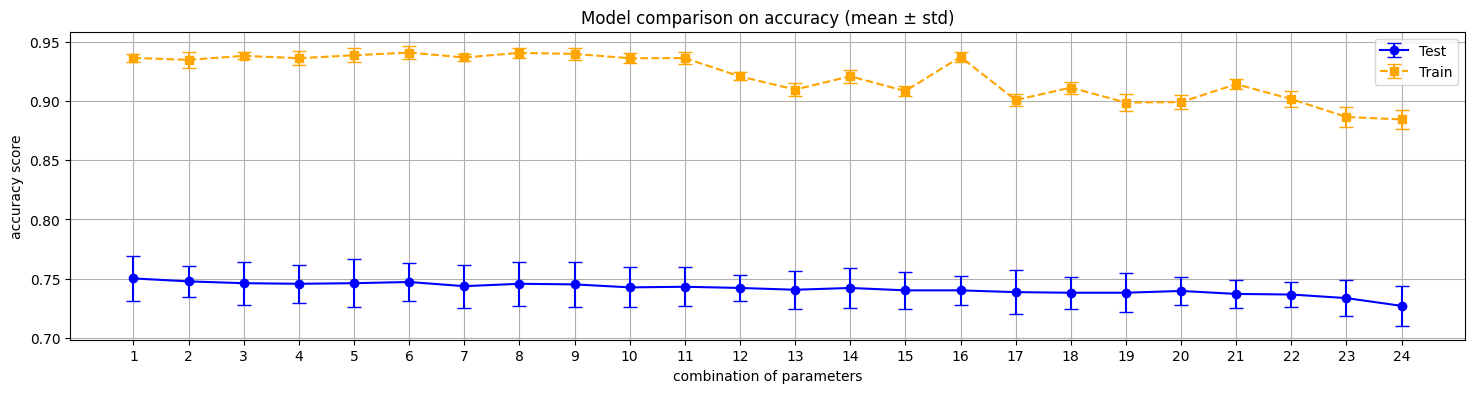

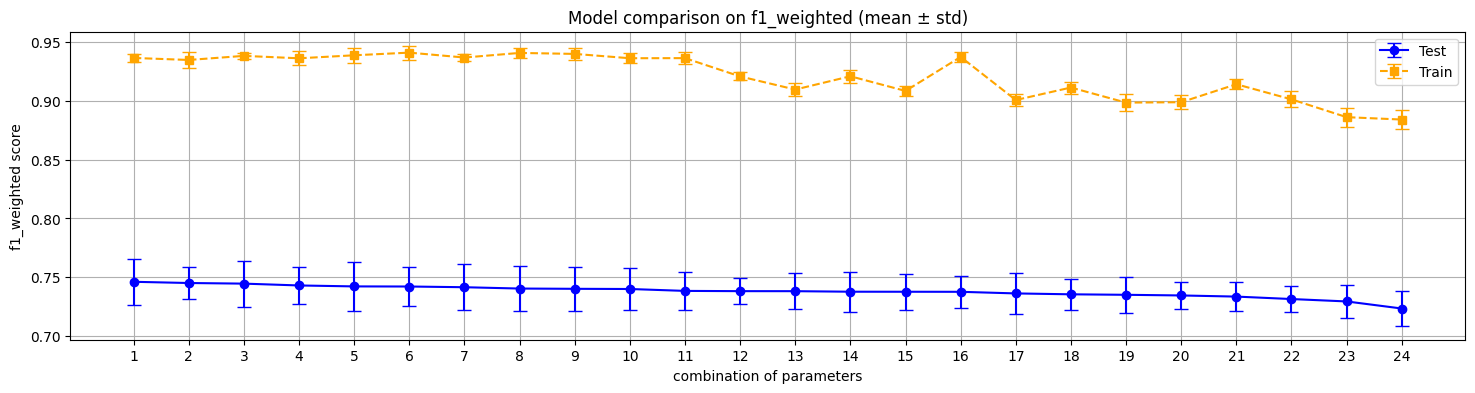

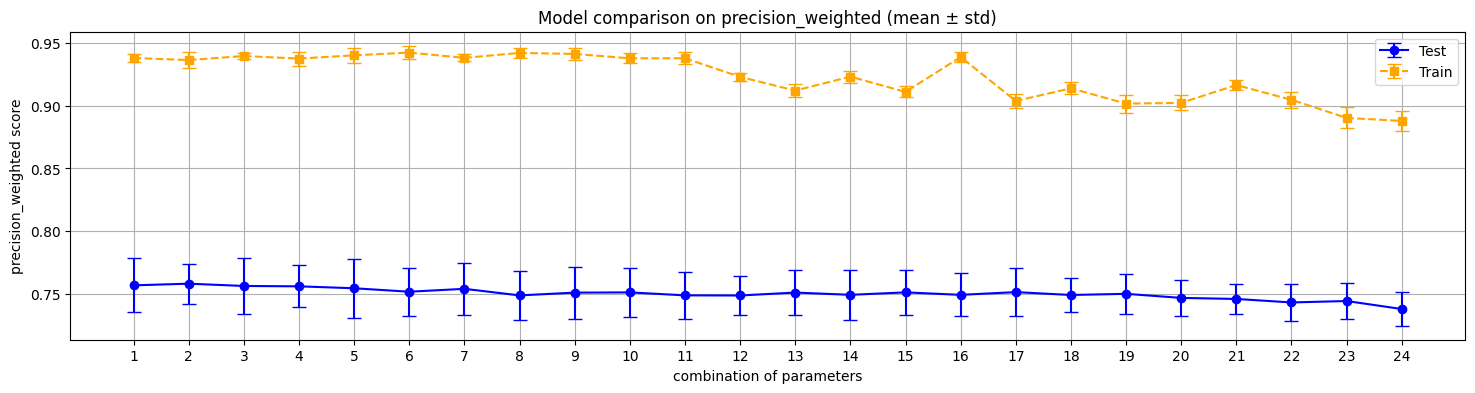

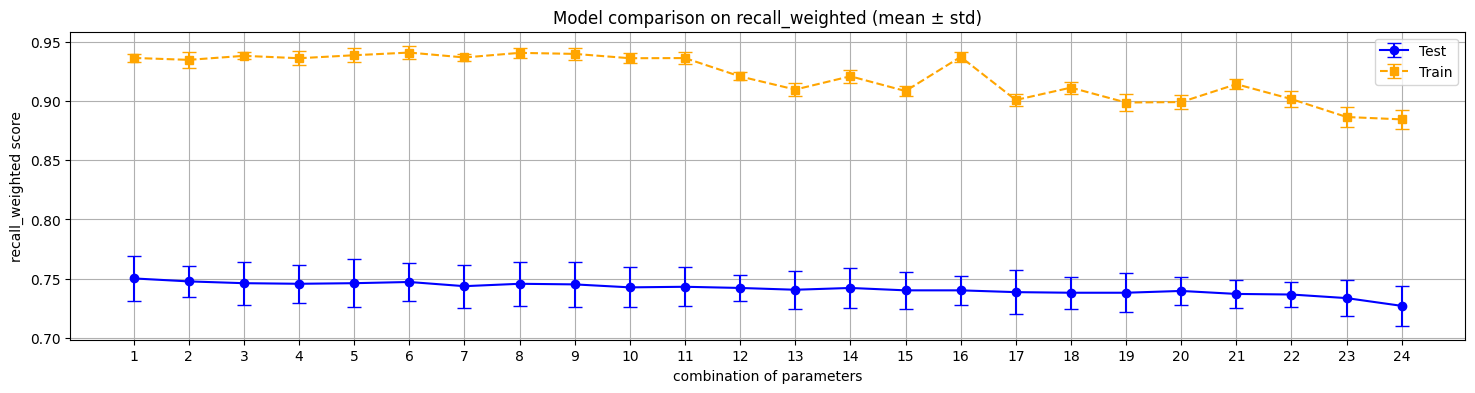

In [ ]:
for metric in scoring:
    data_test = {}
    data_train = {}
    for i in range(len(results_df)):
        col_name = f'{i+1}'
        data_test[col_name] = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]
        data_train[col_name] = [results_df[f'split{fold}_train_{metric}'][i] for fold in range(skf.get_n_splits())]

    df_test = pd.DataFrame(data_test)
    df_train = pd.DataFrame(data_train)

    means_test = df_test.mean()
    stds_test = df_test.std()
    means_train = df_train.mean()
    stds_train = df_train.std()

    plt.figure(figsize=(max(6, len(results_df) * 0.75), 4))

    plt.errorbar(means_test.index, means_test.values, yerr=stds_test.values, fmt='-o', capsize=5, label='Test', color='blue')

    plt.errorbar(means_train.index, means_train.values, yerr=stds_train.values, fmt='--s', capsize=5, label='Train', color='orange')

    plt.ylabel(f'{metric} score')
    plt.xlabel('Combination of parameters')
    plt.title(f'Model comparison on {metric} (mean ± std)')
    plt.legend()
    plt.grid(True)
    plt.show()

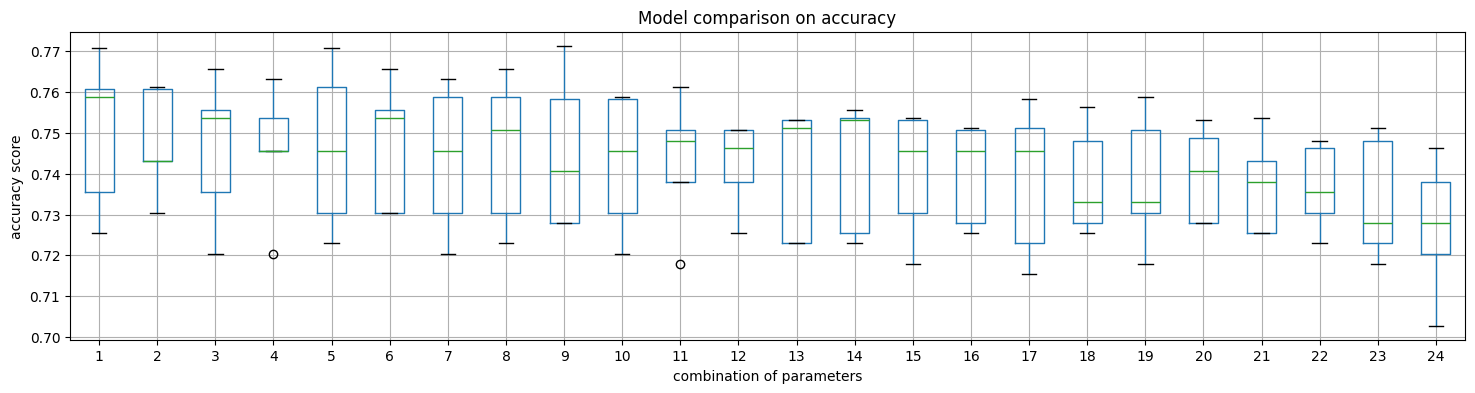

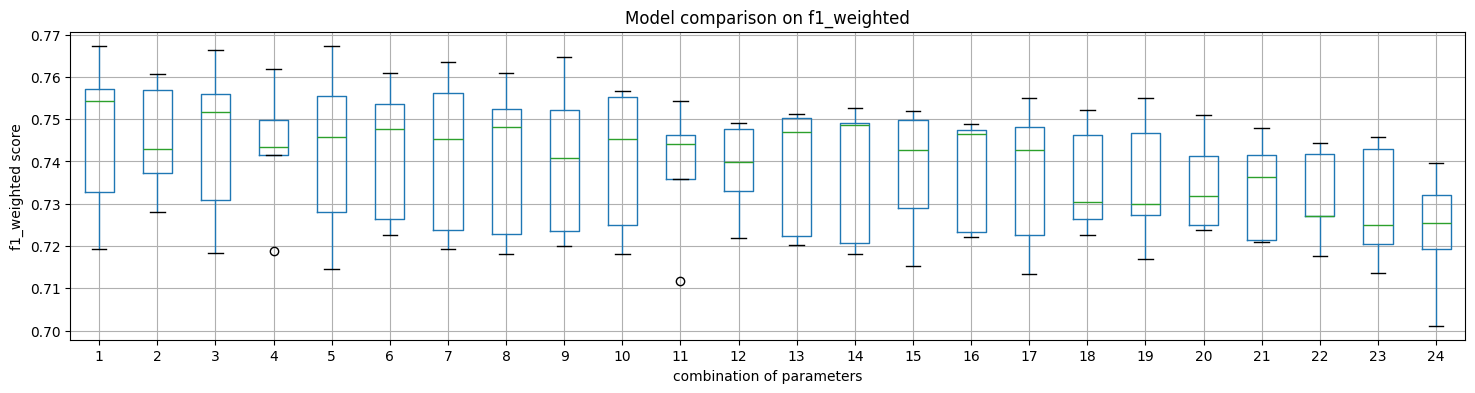

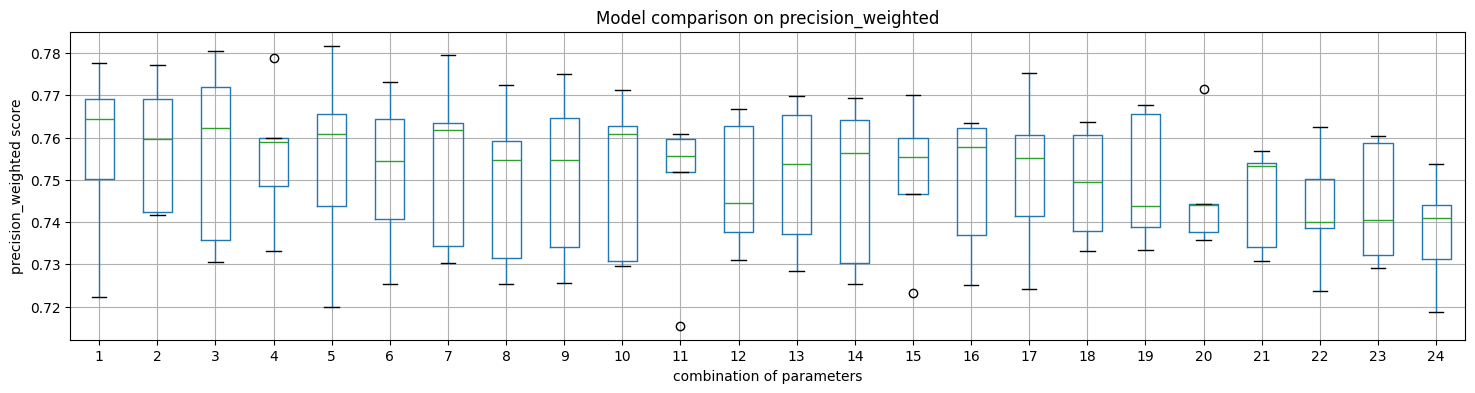

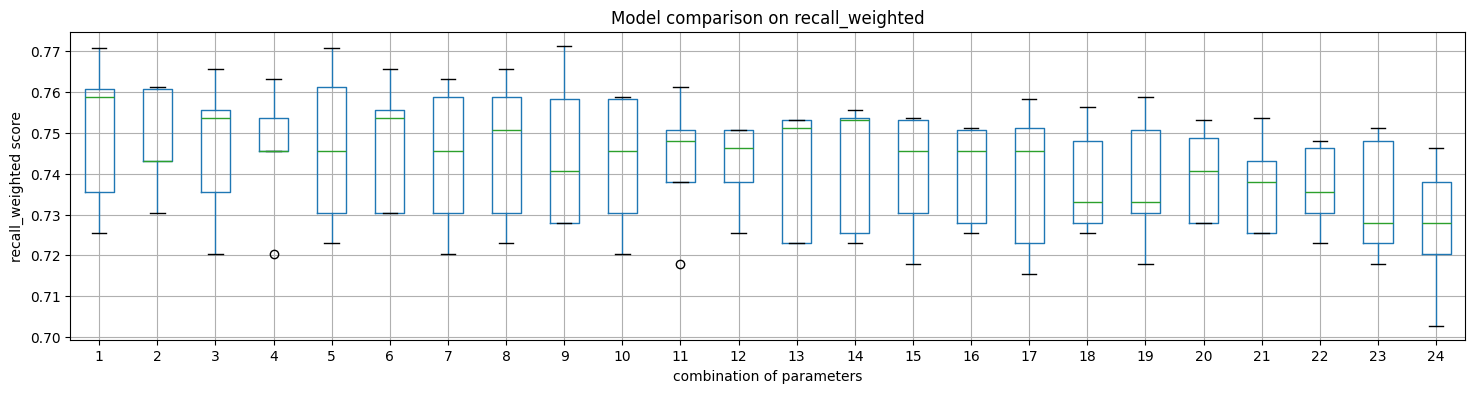

In [ ]:
for metric in scoring:
    data = {}
    for i in range(len(results_df)):
        col_name = f'{i+1}'
        data[col_name] = [results_df[f'split{fold}_test_{metric}'][i] for fold in range(skf.get_n_splits())]

    df_metric = pd.DataFrame(data)
    ax = df_metric.boxplot(figsize=(max(6, len(results_df) * 0.75), 4))
    ax.set_ylabel(f'{metric} score')
    ax.set_xlabel('Combination of parameters')
    plt.title(f'Model comparison on {metric}')
    plt.grid(True)
    plt.show()